In [14]:
import sys
sys.path.append('../')
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [16]:
dts=[24,734,25,516,31,754,31,877,22,814,21,362,26,764,20,809,16,223,22,1066]
c1=dts[::2]
c2=dts[1::2]

Airline_data=pd.DataFrame({'Year':[1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
'Fatal accidents':c1,  
'Passenger deaths':c2,
'Death rate':[0.19,0.12,0.15,0.16,0.14,0.06,0.13,0.13,0.03,0.15]}).set_index('Year')
Airline_data['Miles flown [100 mln miles]']=np.round(Airline_data['Passenger deaths']/Airline_data['Death rate'])

## generation of vector for plotting samples under histograms
acc=[]
dta_cnt=[]
for k in Airline_data['Fatal accidents']:  
    dta_cnt.append(-(1.+acc.count(k)))
    acc.append(k)
dta_cnt=np.array(dta_cnt)

Airline_data

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


In [21]:
#Mean of passenger deaths
Airline_data['Passenger deaths'].mean()

691.9

In [22]:
#Next I will try to do prior predictive checks with poisson distribution

In [47]:
with open('prior_deaths.stan', 'r') as file:
    print(file.read())


generated quantities {
    real lambda = normal_rng(692,250); //Mean is the mean of data, sigma higher for better representation
    int deaths = poisson_rng(lambda);
}


In [48]:
model_ppc=stan_utility.compile_model('prior_deaths.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecef5bad59d11deb8ff2fd72811fb127 NOW.


In [49]:
R = 1000
sim=model_ppc.sampling(data=dict(), 
                       iter=R, warmup=0, 
                       chains=1, 
                       refresh=R,
                       algorithm='Fixed_param',
                       seed=29042020)

In [50]:
params_sim=sim.extract()
lambda_sim=params_sim['lambda']
deaths_sim=params_sim['deaths']

/home/rsi96/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/rsi96/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


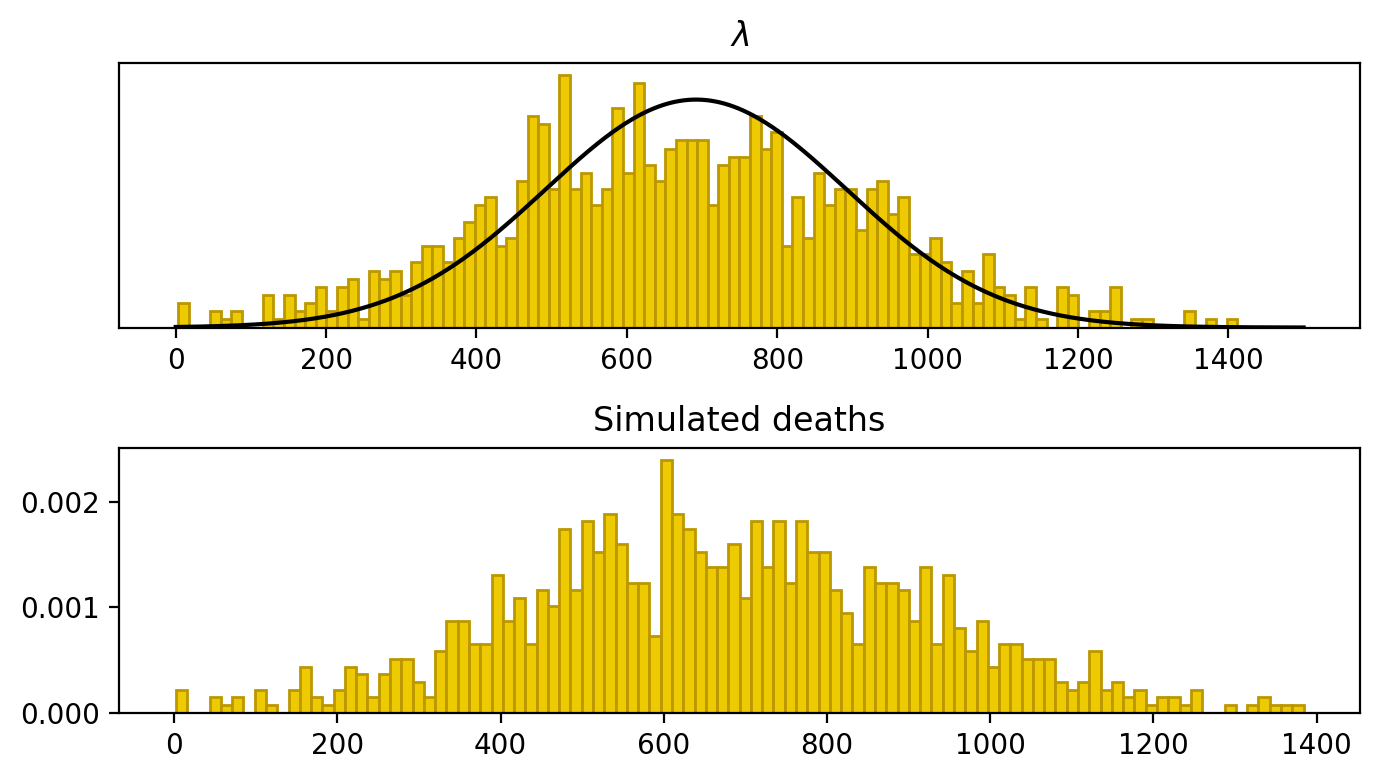

In [51]:
fig = plt.figure(figsize=(7, 4))

gs = fig.add_gridspec(2,1)
ax1 = fig.add_subplot(gs[1])
ax1.hist(deaths_sim,bins=100,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title('Simulated deaths')

ax2 = fig.add_subplot(gs[0])
ax2.set_yticks([])
ax2.hist(lambda_sim,bins=100,color=dark,edgecolor=dark_highlight,density=True)

ax2.plot(x,y,'black')
ax2.set_title('$\lambda$')
ax2.set_yticks([])

fig.tight_layout()
plt.show()



In [52]:
#Prior predictive is quite belivable so i think its ok

In [53]:
#Next is posterior and interference

In [54]:
with open('posterior_deaths.stan', 'r') as file:
    print(file.read())

data {
    int N;
    int deaths[N];
}

parameters{
    real<lower=0> lambda;
}

model {
    lambda ~ normal(692,250);
    deaths ~ poisson(lambda);
}

generated quantities {
    int deaths_gen = poisson_rng(lambda);
}


In [55]:
model_1_fit=stan_utility.compile_model('posterior_deaths.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_165cdf3f314dbefe0df173a6710ce28c NOW.


In [56]:
fit=model_1_fit.sampling(data=dict(N=len(Airline_data['Passenger deaths']),
                                   deaths=Airline_data['Passenger deaths']),
                         seed=28052020)

In [57]:
az.summary(fit,var_names=['lambda'],round_to=2,kind='stats')

,mean,sd,hpd_3%,hpd_97%
lambda,691.85,8.25,676.61,707.47


In [58]:
params_fit=fit.extract()
lambda_fit=params_fit['lambda']
deaths_pred=params_fit['deaths_gen']

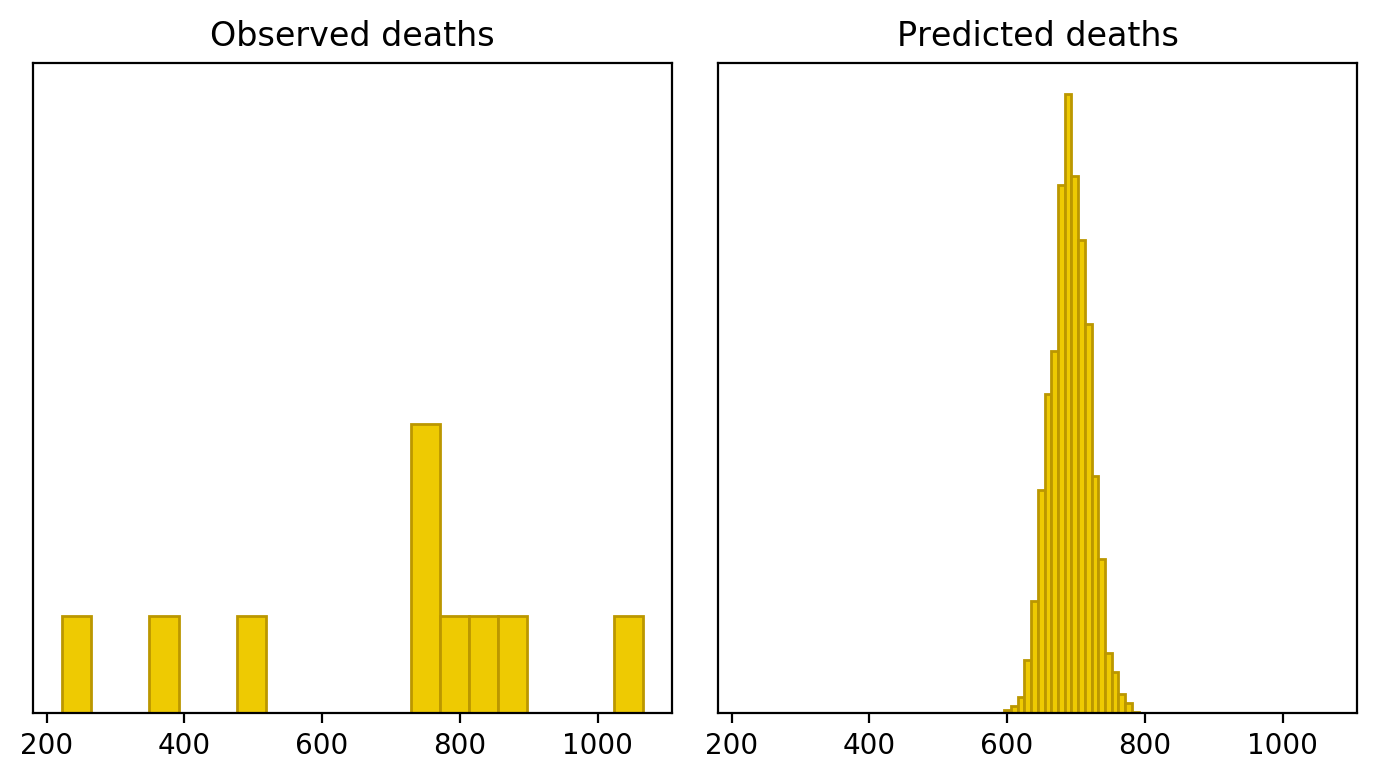

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4),sharex=True,sharey=True)
ax=axes[0]
ax.hist(Airline_data['Passenger deaths'],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax.set_title('Observed deaths')
ax.set_yticks(());
ax2=axes[1]
ax2.hist(deaths_pred,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('Predicted deaths')
ax2.set_yticks(());
fig.tight_layout()

plt.show()

In [ ]:
# We can see that predicted deaths are tightly packed around mean when observed deaths were spread wider. I think that is possible becouse we had few data and wit